### Import Modules and Libraries

In [1]:
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.preprocessing import image
import keras.backend as K
import numpy as np
import cv2
import sys
from google.colab.patches import cv2_imshow
import random

Using TensorFlow backend.


### Mount Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


### Import Trained Model from Google Drive

In [3]:
from keras.models import load_model

filepath="/content/gdrive/My Drive/Colab Notebooks/Training-9/model-96-0.81.hdf5"

model = load_model(filepath)

W0624 17:17:09.556338 140567534434176 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0624 17:17:09.610913 140567534434176 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0624 17:17:09.668907 140567534434176 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:245: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0624 17:17:09.670082 140567534434176 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0624 17:17:09.671432 140567534

### Model Summary

In [4]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 128)       73856     
__________

### Import Dataset

In [5]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()

170500096/170498071 [==============================] - 4s 0us/step


### Function to Resize and Display Image

In [0]:
def disp(x):
  # Resize the image
  x = cv2.resize(x, (200,200))
  cv2_imshow(x)

### Display Random Sample Image

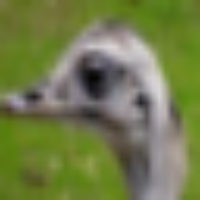

In [7]:
img_index = random.randint(0, 10000)

# Convert Image to an Array
x = image.img_to_array(test_features[img_index])
x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
disp(x)

### Pre-process and Reshape Image

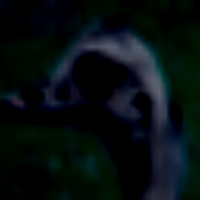

In [8]:
# Pre-process image 
x = preprocess_input(x)
disp(x)

# Expand the dimension of an image to load the image in model
# Model expects a 4-dimension image
x = np.expand_dims(x, axis=0)

### Check Prediction of Model for the Image and take output of Penultimate Convolution Layer

In [0]:
# Class prediction for above image
preds = model.predict(x)

# Topmost class index
class_idx = np.argmax(preds[0])
class_output = model.output[:, class_idx]

# Get output of penultimate convolution layer
# As shown in model summary, the output of `conv2d_10` layer is 8x8x10
last_conv_layer = model.get_layer("conv2d_10")

### Gradients of Output
- Compute gradient of class output with respect to fearure map. 
- Pool the gradients over all the axes leaving out the channel dimension
- Weigh the output feature map with the computed gradient values

In [0]:
# Compute gradients
grads = K.gradients(class_output, last_conv_layer.output)[0]

# Pooled gradients
pooled_grads = K.mean(grads, axis=(0, 1, 2))
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([x])

# Weight output feature map with computed gradients
for i in range(10):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

### Heatmap

In [0]:
# Average the weighed feature map along the channel dimension
heatmap = np.mean(conv_layer_output_value, axis=-1)

# Maximum value on heatmap
heatmap = np.maximum(heatmap, 0)

# Normalize values betwenn 0 & 1
heatmap /= np.max(heatmap)

### Result

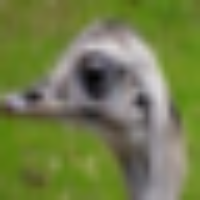

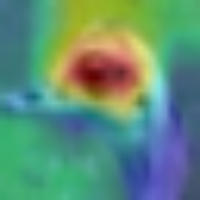

In [12]:
# Import Image and change it to appropriate color space
img = test_features[img_index]
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Resize heatmap to image size
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

# Scaleup the values of heatmap to range of 0-255
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# Superimpose input image and activation image
superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

disp(img)
disp(superimposed_img)

---

### Function to perform above Processing 

In [0]:
def viz(input_img, layer_name, channel_number):
  x = image.img_to_array(input_img)
  x = preprocess_input(x)
  x = np.expand_dims(x, axis=0)
  
  preds = model.predict(x)
  class_idx = np.argmax(preds[0])
  class_output = model.output[:, class_idx]
  last_conv_layer = model.get_layer(layer_name)
  
  grads = K.gradients(class_output, last_conv_layer.output)[0]
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
  pooled_grads_value, conv_layer_output_value = iterate([x])
  for i in range(channel_number):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
  
  heatmap = np.mean(conv_layer_output_value, axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  
  heatmap = cv2.resize(heatmap, (input_img.shape[1], input_img.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  heatmap = np.asarray(heatmap, np.float32)
  superimposed_img = cv2.addWeighted(input_img, 0.6, heatmap, 0.4, 0)
  
  return superimposed_img

### Evaluate

Image Index:  4682
Input Image: 


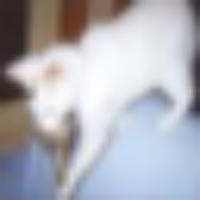

Activation Image: 


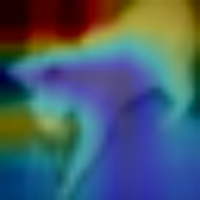

In [44]:
# Generate random index number for test dataset
img_index = random.randint(0, 10000)
print("Image Index: ", img_index)

# Input Image
preprocess_img = image.img_to_array(test_features[img_index])
preprocess_img = cv2.cvtColor(preprocess_img, cv2.COLOR_BGR2RGB)
print("Input Image: ")
disp(preprocess_img)

# GradCam activation image
out = viz(preprocess_img, layer_name="conv2d_10", channel_number=10)
print("Activation Image: ")
disp(out)

The reddish portion in the image shows the area in which the neurons are getting activated

---



### Images to compare with model trained with cutout augmentation technique

Input Image - 1 : 


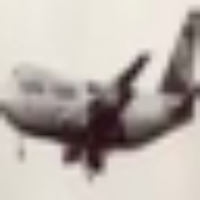

Input Image - 2 : 


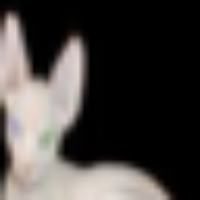

Input Image - 3 : 


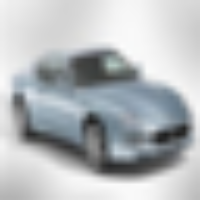

Input Image - 4 : 


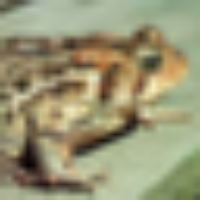

Input Image - 5 : 


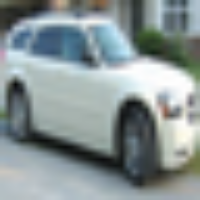

Input Image - 6 : 


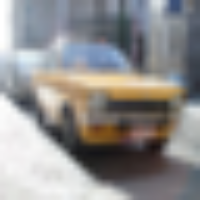

Input Image - 7 : 


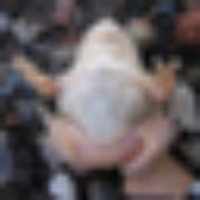

Input Image - 8 : 


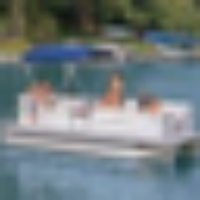

In [40]:
imgs_indx = [4305, 2840, 8990, 6330, 2450, 1134, 1094, 8159]

for i in range(len(imgs_indx)):
  preprocess_img = image.img_to_array(test_features[imgs_indx[i]])
  preprocess_img = cv2.cvtColor(preprocess_img, cv2.COLOR_BGR2RGB)
  print("Input Image -", i+1, ": ")
  disp(preprocess_img)

Activation Image - 1 : 


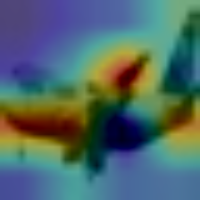

Activation Image - 2 : 


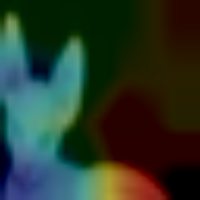

Activation Image - 3 : 


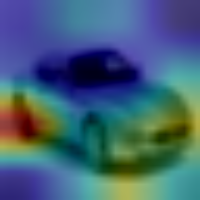

Activation Image - 4 : 


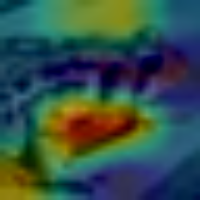

Activation Image - 5 : 


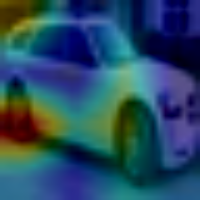

Activation Image - 6 : 


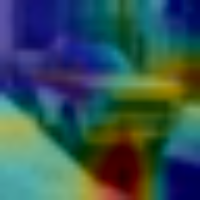

Activation Image - 7 : 


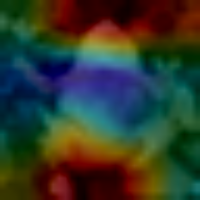

Activation Image - 8 : 


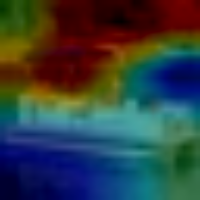

In [45]:
# GradCam activation image
for i in range(len(imgs_indx)):
  preprocess_img = image.img_to_array(test_features[imgs_indx[i]])
  preprocess_img = cv2.cvtColor(preprocess_img, cv2.COLOR_BGR2RGB)
  out = viz(preprocess_img, layer_name="conv2d_10", channel_number=10)
  print("Activation Image -", i+1, ": ")
  disp(out)

---

#### Rough Work:
Tried with Matplotlib but got errors due to different color spaces of OpenCV and Matplotlib

In [0]:
# from matplotlib import pyplot as plt

# imgs_indx = [4305, 2840, 8990, 6330, 2450, 1134, 1094, 8159]

# for i in range(len(imgs_indx)):
#   print(imgs_indx[i])
# #   preprocess_img = cv2.cvtColor(test_features[imgs_indx[i]], cv2.COLOR_BGR2RGB)
#   plt.subplot(2, 4, i+1)
#   plt.rcParams['figure.figsize'] = (10,10)
#   plt.imshow(test_features[imgs_indx[i]])
#   plt.xticks([])
#   plt.yticks([])

In [0]:
# for i in range(len(imgs_indx)):
#   plt.subplot(2, 4, i+1)
#   plt.rcParams['figure.figsize'] = (10,10)
# #   print(imgs_indx[i])
# #   pre_process = image.img_to_array(test_features[imgs_indx[i]])
#   pre_process = cv2.cvtColor(test_features[imgs_indx[i]], cv2.COLOR_BGR2RGB)
#   out = viz(pre_process, layer_name="conv2d_10", channel_number=10, reading_type='plt')
#   plt.imshow(out)
#   plt.xticks([])
#   plt.yticks([])